In [40]:
library(zellkonverter)
library(SingleCellExperiment)
library(dreamlet)

options(repr.plot.width = 20, repr.plot.height = 16, repr.plot.res = 100)

# Preprocess

In [41]:
# Create SingleCellExperiment object that points to on-disk H5AD file, R reader as more than 2**31 elements.
sce <- readH5AD('preprocessed_de_immuneaging4_small.h5ad', use_hdf5=TRUE, verbose = TRUE)
sce

ℹ Using the Python reader

ℹ Using anndata version 0.8.0

⠙ Reading './preprocessed_de_immuneaging4_small.h5ad '
✔ Read ./preprocessed_de_immuneaging4_small.h5ad  32.1s]


ℹ Converting AnnData to SingleCellExperiment

ℹ uns is empty and was skipped

ℹ Converting AnnData to SingleCellExperiment
ℹ Converting X matrix to assay
✔ X matrix converted to assay [8.7s]


ℹ Converting AnnData to SingleCellExperiment

ℹ layers is empty and was skipped

ℹ Converting AnnData to SingleCellExperiment
ℹ Converting var to rowData

! The names of these selected var columns have been modified to match R conventions: 'is_highly_variable_gene_batch_key_donor_id+tissue' -> 'is_highly_variable_gene_batch_key_donor_id.tissue'

ℹ Converting var to rowData
Warning message:
“The names of these selected var columns have been modified to match R conventions: 'is_highly_variable_gene_batch_key_donor_id+tissue' -> 'is_highly_variable_gene_batch_key_donor_id.tissue'”
✔ var converted to rowData s]


ℹ Converting AnnDa

class: SingleCellExperiment 
dim: 14798 1241353 
metadata(0):
assays(1): X
rownames(14798): A1BG A3GALT2 ... ZYX ZZEF1
rowData names(11): gene_ids feature_types ... gene_names n_counts
colnames(1241353): CGAATGTCAATAAGCA-1_CZINY-0536-14
  TTGGCAATCTAACTGG-1_CZINY-0341-4 ... ACGTCAAAGACTCGGA-1_CZINY-0527-6
  TAGTGGTGTCAGGACA-1_CZINY-0169-7
colData names(39): n_genes n_genes_by_counts ... age_int age_group
reducedDimNames(22): BCR_IR TCR_IR ... removed_proteins versions
mainExpName: NULL
altExpNames(0):

In [42]:
sce

class: SingleCellExperiment 
dim: 14798 1241353 
metadata(0):
assays(1): X
rownames(14798): A1BG A3GALT2 ... ZYX ZZEF1
rowData names(11): gene_ids feature_types ... gene_names n_counts
colnames(1241353): CGAATGTCAATAAGCA-1_CZINY-0536-14
  TTGGCAATCTAACTGG-1_CZINY-0341-4 ... ACGTCAAAGACTCGGA-1_CZINY-0527-6
  TAGTGGTGTCAGGACA-1_CZINY-0169-7
colData names(39): n_genes n_genes_by_counts ... age_int age_group
reducedDimNames(22): BCR_IR TCR_IR ... removed_proteins versions
mainExpName: NULL
altExpNames(0):

In [43]:
pb <- aggregateToPseudoBulk(
    sce,
    assay = "X",
    cluster_id = "celltypes_steven",
    sample_id = "donor_tissue",
    verbose = TRUE)
# one 'assay' per cell type
assayNames(pb)
rownames(pb) <- rowData(sce)$genes
saveRDS(pb, file='pseudobulk_immuneaging_fine.rds')

Processing block [[1/1, 1/1471]] ... 
OK
Processing block [[1/1, 2/1471]] ... 
OK
Processing block [[1/1, 3/1471]] ... 
OK
Processing block [[1/1, 4/1471]] ... 
OK
Processing block [[1/1, 5/1471]] ... 
OK
Processing block [[1/1, 6/1471]] ... 
OK
Processing block [[1/1, 7/1471]] ... 
OK
Processing block [[1/1, 8/1471]] ... 
OK
Processing block [[1/1, 9/1471]] ... 
OK
Processing block [[1/1, 10/1471]] ... 
OK
Processing block [[1/1, 11/1471]] ... 
OK
Processing block [[1/1, 12/1471]] ... 
OK
Processing block [[1/1, 13/1471]] ... 
OK
Processing block [[1/1, 14/1471]] ... 
OK
Processing block [[1/1, 15/1471]] ... 
OK
Processing block [[1/1, 16/1471]] ... 
OK
Processing block [[1/1, 17/1471]] ... 
OK
Processing block [[1/1, 18/1471]] ... 
OK
Processing block [[1/1, 19/1471]] ... 
OK
Processing block [[1/1, 20/1471]] ... 
OK
Processing block [[1/1, 21/1471]] ... 
OK
Processing block [[1/1, 22/1471]] ... 
OK
Processing block [[1/1, 23/1471]] ... 
OK
Processing block [[1/1, 24/1471]] ... 
OK
P

[1] "b_age"                 "b_gc"                  "b_memory"             
 [4] "b_naive"               "cd3_gd"                "cd4_cm"               
 [7] "cd4_naive"             "cd4_tem"               "cd4_temra"            
[10] "cd4_treg"              "cd4_trm"               "cd8_cm"               
[13] "cd8_mait"              "cd8_naive"             "cd8_tem"              
[16] "cd8_temra"             "cd8_trm"               "dc1"                  
[19] "dc2"                   "dc_migratory"          "ilc1"                 
[22] "ilc3"                  "macrophage"            "mast_cell"            
[25] "monocyte_classical"    "monocyte_nonclassical" "nk_cd56br"            
[28] "nk_cd56dim"            "nk_ilc_precursor"      "pdc"                  
[31] "plasma_cell"           "plasmablast"

In [44]:
library(BiocParallel)
multicoreParam <- MulticoreParam(workers = 8)
multicoreParam

class: MulticoreParam
  bpisup: FALSE; bpnworkers: 8; bptasks: 0; bpjobname: BPJOB
  bplog: FALSE; bpthreshold: INFO; bpstopOnError: TRUE
  bpRNGseed: ; bptimeout: NA; bpprogressbar: FALSE
  bpexportglobals: TRUE; bpexportvariables: FALSE; bpforceGC: FALSE
  bpfallback: TRUE
  bplogdir: NA
  bpresultdir: NA
  cluster type: FORK

In [45]:
rownames(pb) <- rowData(pb)$gene_names

In [63]:
# Normalize and apply voom/voomWithDreamWeights
res.proc = processAssays( pb, ~ tissue + cmv + age_group + sex + chemistry + site + 0, min.cells=10, min.count=10, min.prop=0.2,
                         BPPARAM=multicoreParam)

# the resulting object of class dreamletProcessedData stores
# normalized data and other information
details(res.proc)

  b_age...
0.42 secs

  b_gc...
0.39 secs

  b_memory...
4.2 secs

  b_naive...
3.4 secs

  cd3_gd...
2.3 secs

  cd4_cm...
4.5 secs

  cd4_naive...
4 secs

  cd4_tem...
3.4 secs

  cd4_temra...
1.1 secs

  cd4_treg...
3.4 secs

  cd4_trm...
4 secs

  cd8_cm...
1.1 secs

  cd8_mait...
1.3 secs

  cd8_naive...
2.7 secs

  cd8_tem...
2.6 secs

  cd8_temra...
2.5 secs

  cd8_trm...
4.1 secs

  dc1...


Coefficients not estimable: siteUK 


Warning message:
“Partial NA coefficients for 881 probe(s)”
0.27 secs

  dc2...
1.6 secs

  dc_migratory...
0.72 secs

  ilc1...
1.7 secs

  ilc3...
1.4 secs

  macrophage...
4.1 secs

  mast_cell...
1.4 secs

  monocyte_classical...
3.5 secs

  monocyte_nonclassical...
2.5 secs

  nk_cd56br...
2.8 secs

  nk_cd56dim...
3.5 secs

  nk_ilc_precursor...
1.9 secs

  pdc...
0.81 secs

  plasma_cell...
1.9 secs

  plasmablast...
3 secs

Warning message in processAssays(pb, ~tissue + cmv + age_group + sex + chemistry + :
“Terms dropped from formulas for 2 assays.
 Run details() on result for more information”


assay,n_retain,formula,formDropsTerms,n_genes,n_errors,error_initial
<chr>,<int>,<chr>,<lgl>,<int>,<int>,<lgl>
b_age,15,~tissue + cmv + age_group + sex + site - 1,TRUE,1436,0,FALSE
b_gc,18,~tissue + cmv + age_group + sex + site - 1,TRUE,1172,0,FALSE
b_memory,151,~tissue + cmv + age_group + sex + chemistry + site - 1,FALSE,8978,0,FALSE
b_naive,139,~tissue + cmv + age_group + sex + chemistry + site - 1,FALSE,7476,0,FALSE
cd3_gd,110,~tissue + cmv + age_group + sex + chemistry + site - 1,FALSE,4213,0,FALSE
cd4_cm,159,~tissue + cmv + age_group + sex + chemistry + site - 1,FALSE,9174,0,FALSE
cd4_naive,137,~tissue + cmv + age_group + sex + chemistry + site - 1,FALSE,8166,0,FALSE
cd4_tem,146,~tissue + cmv + age_group + sex + chemistry + site - 1,FALSE,6712,0,FALSE
cd4_temra,59,~tissue + cmv + age_group + sex + chemistry + site - 1,FALSE,2369,0,FALSE


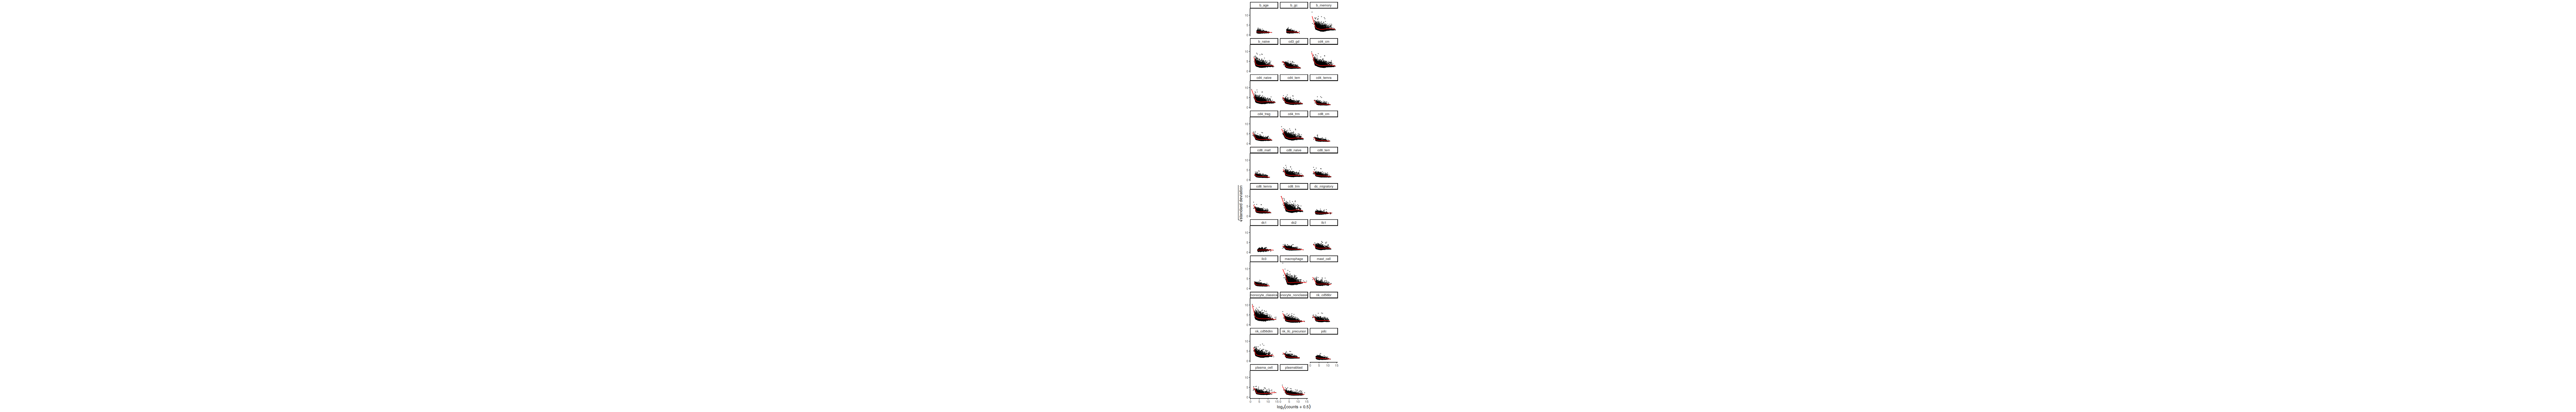

In [64]:
# show voom plot for each cell clusters 
options(repr.plot.width = 100, repr.plot.height = 16, repr.plot.res = 100)
plotVoom(res.proc)

In [65]:
saveRDS(res.proc, file='pseudobulk_immuneaging_preprocessed_fine_redo.rds')

# DE tissue

In [66]:
res.proc <- readRDS(pb, file='pseudobulk_immuneaging_preprocessed_fine_redo.rds')

In [67]:
res.proc

class: dreamletProcessedData 
assays(32): b_age b_gc ... plasma_cell plasmablast
colData(17): donor site ... age_int age_group
metadata(8): celltypes_steven donor_tissue ... X_scvi_batch
  sum_percolation_score
Samples:
 min: 11 
 max: 160
Genes:
 min: 881 
 max: 9174 
details(7): assay n_retain ... n_errors error_initial

In [72]:
celltypes = c()
for (i in assayNames(res.proc)){
    count <- sum(grepl("BLO", rownames(assay(res.proc, i)$targets)))
    print(paste0(i, '   contains n blood samples  ', count))
    if(count > 8) {
        celltypes <- c(celltypes, i)
    }
}
celltypes

[1] "b_age   contains n blood samples  1"
[1] "b_gc   contains n blood samples  0"
[1] "b_memory   contains n blood samples  15"
[1] "b_naive   contains n blood samples  17"
[1] "cd3_gd   contains n blood samples  11"
[1] "cd4_cm   contains n blood samples  19"
[1] "cd4_naive   contains n blood samples  19"
[1] "cd4_tem   contains n blood samples  17"
[1] "cd4_temra   contains n blood samples  9"
[1] "cd4_treg   contains n blood samples  18"
[1] "cd4_trm   contains n blood samples  1"
[1] "cd8_cm   contains n blood samples  15"
[1] "cd8_mait   contains n blood samples  6"
[1] "cd8_naive   contains n blood samples  19"
[1] "cd8_tem   contains n blood samples  18"
[1] "cd8_temra   contains n blood samples  17"
[1] "cd8_trm   contains n blood samples  5"
[1] "dc1   contains n blood samples  1"
[1] "dc2   contains n blood samples  3"
[1] "dc_migratory   contains n blood samples  0"
[1] "ilc1   contains n blood samples  2"
[1] "ilc3   contains n blood samples  2"
[1] "macrophage   contains 

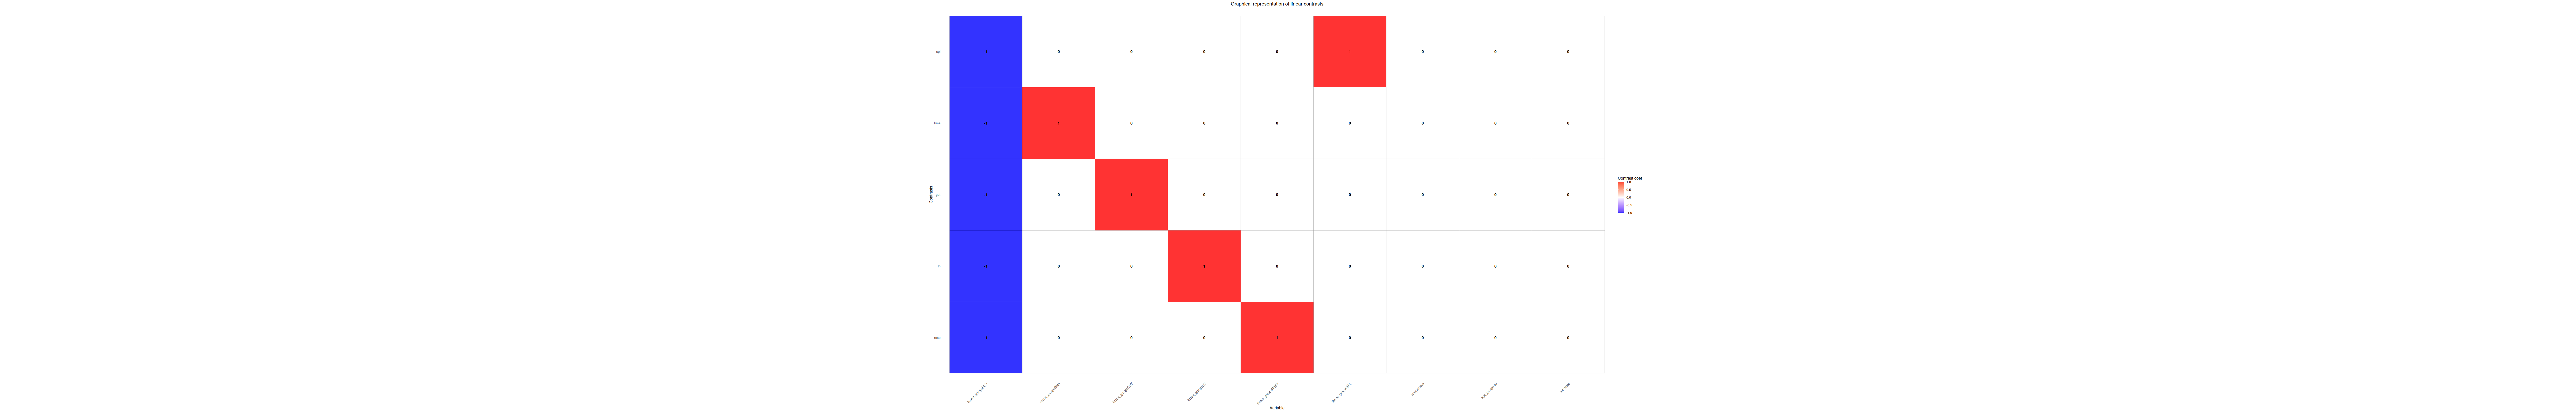

In [74]:
form <- ~ tissue_groups + cmv + age_group + sex + (1|chemistry) + (1|site) + 0

# Define contrasts
# Note that for each contrass, the weights sum to 1
L <- makeContrastsDream(form, colData(res.proc), contrasts = c(
    resp = "tissue_groupsRESP - tissue_groupsBLO",
    ln = "tissue_groupsLN - tissue_groupsBLO",
    gut = "tissue_groupsGUT - tissue_groupsBLO",
    bma = "tissue_groupsBMA - tissue_groupsBLO",
    spl = "tissue_groupsSPL - tissue_groupsBLO")
)

# Plot to visualize contrasts matrix
plotContrasts(L)

In [75]:
form <- ~ tissue_groups + cmv + age_group + sex + (1|chemistry) + (1|site) + 0

# Differential expression analysis within each assay,
# evaluated on the voom normalized data
res.dl2 <- dreamlet(
    res.proc,
    form,
    assays=celltypes,
    colData(res.proc),
    contrasts = c(
        resp = "tissue_groupsRESP - tissue_groupsBLO",
        ln = "tissue_groupsLN - tissue_groupsBLO",
        gut = "tissue_groupsGUT - tissue_groupsBLO",
        bma = "tissue_groupsBMA - tissue_groupsBLO",
        spl = "tissue_groupsSPL - tissue_groupsBLO"),
    computeResiduals=TRUE,
    BPPARAM=multicoreParam
)

# names of estimated coefficients
coefNames(res.dl2) 

  b_memory...
14 mins

  b_naive...
11 mins

  cd3_gd...
6.4 mins

  cd4_cm...
14 mins

  cd4_naive...
12 mins

  cd4_tem...
10 mins

  cd4_temra...
3.7 mins

  cd4_treg...
9 mins

  cd8_cm...
3.1 mins

  cd8_naive...
9.8 mins

  cd8_tem...
7.2 mins

  cd8_temra...
6.1 mins

  monocyte_classical...
13 mins

  monocyte_nonclassical...
9.3 mins

  nk_cd56br...
6.2 mins

  nk_cd56dim...
12 mins

  nk_ilc_precursor...
4.3 mins

  plasmablast...
11 mins


Of 107,439 models fit across all assays, 0.449% failed




[1] "resp"              "ln"                "gut"              
 [4] "bma"               "spl"               "tissue_groupsBLO" 
 [7] "tissue_groupsBMA"  "tissue_groupsGUT"  "tissue_groupsLN"  
[10] "tissue_groupsRESP" "tissue_groupsSPL"  "cmvpositive"      
[13] "age_group>40"      "sexMale"

Warning message:
“Removed 1 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 54 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


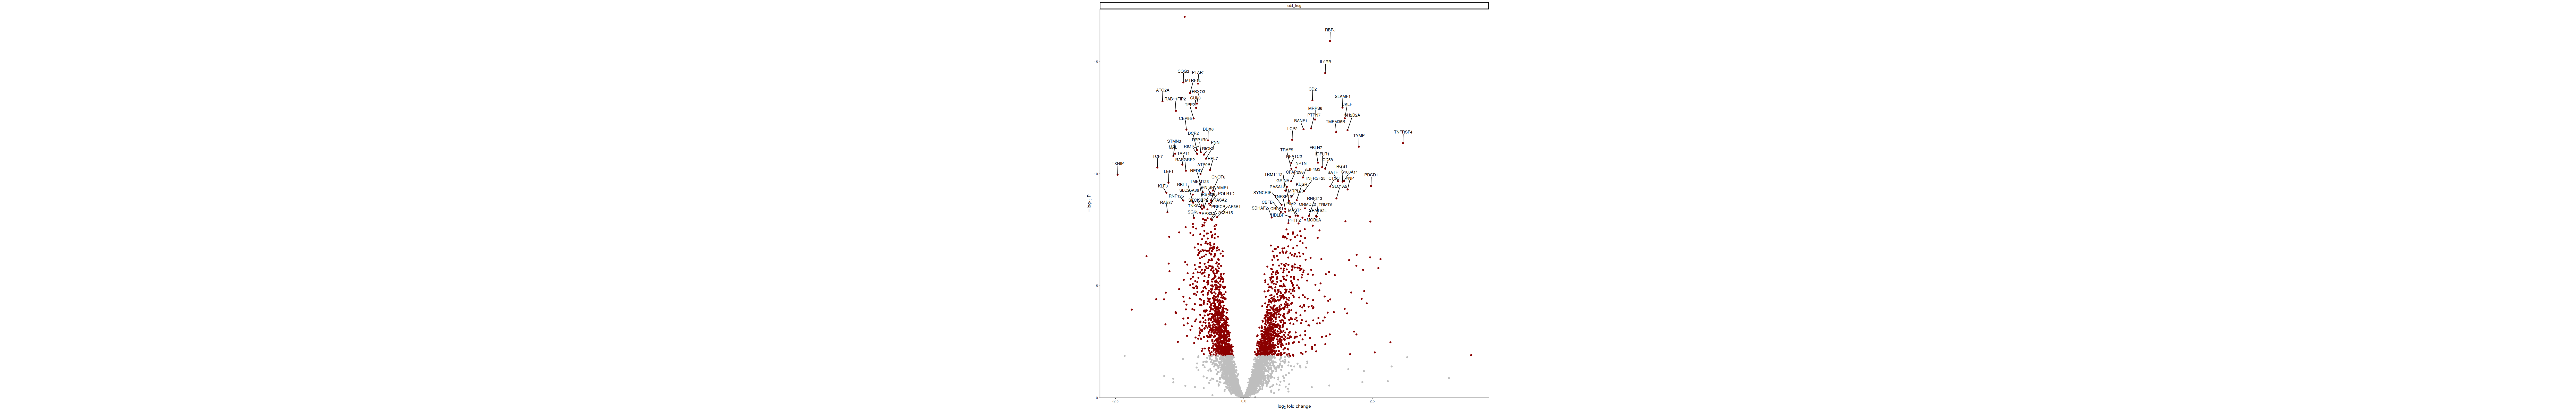

In [76]:
plotVolcano(res.dl2, coef='resp', nGenes=100, assay='cd4_treg')

In [77]:
form <- ~ tissue_groups + cmv + age_group + sex + chemistry + site + 0

# Differential expression analysis within each assay,
# evaluated on the voom normalized data
res.dl <- dreamlet(
    res.proc,
    form,
    assays=celltypes,
    colData(res.proc),
    contrasts = c(
        resp = "tissue_groupsRESP - tissue_groupsBLO",
        ln = "tissue_groupsLN - tissue_groupsBLO",
        gut = "tissue_groupsGUT - tissue_groupsBLO",
        bma = "tissue_groupsBMA - tissue_groupsBLO",
        spl = "tissue_groupsSPL - tissue_groupsBLO"),
    computeResiduals=TRUE,
    BPPARAM=multicoreParam
)

# names of estimated coefficients
coefNames(res.dl) 

  b_memory...
11 secs

  b_naive...
11 secs

  cd3_gd...
7.9 secs

  cd4_cm...
18 secs

  cd4_naive...
15 secs

  cd4_tem...
13 secs

  cd4_temra...
2.9 secs

  cd4_treg...
9.2 secs

  cd8_cm...
2.7 secs

  cd8_naive...
12 secs

  cd8_tem...
7.8 secs

  cd8_temra...
7.9 secs

  monocyte_classical...
12 secs

  monocyte_nonclassical...
12 secs

  nk_cd56br...
6.3 secs

  nk_cd56dim...
14 secs

  nk_ilc_precursor...
3.2 secs

  plasmablast...
8.8 secs



[1] "resp"              "ln"                "gut"              
 [4] "bma"               "spl"               "tissue_groupsBLO" 
 [7] "tissue_groupsBMA"  "tissue_groupsGUT"  "tissue_groupsLN"  
[10] "tissue_groupsRESP" "tissue_groupsSPL"  "cmvpositive"      
[13] "age_group>40"      "sexMale"           "chemistry5'v2"    
[16] "siteUK"

Warning message:
“Removed 1 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 75 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


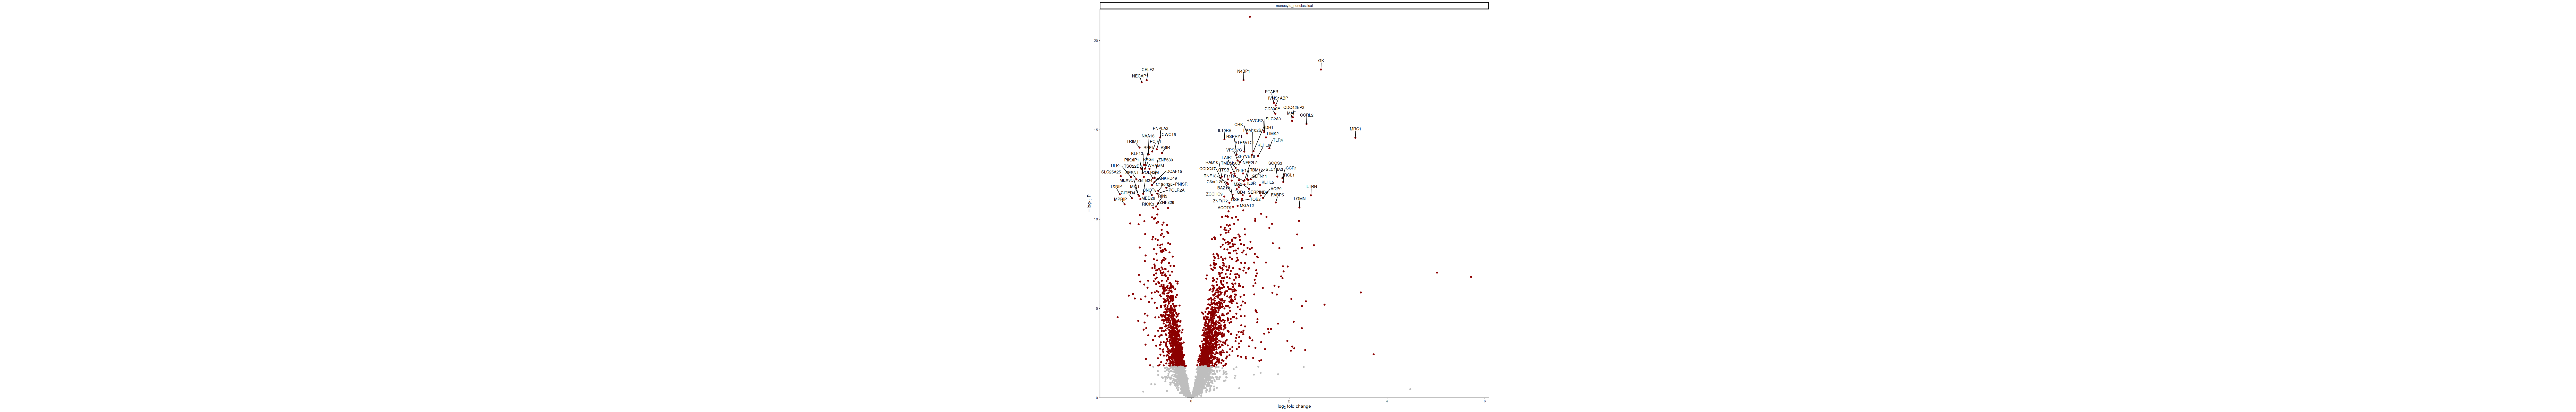

In [78]:
plotVolcano(res.dl, coef='resp', nGenes=100, assay='monocyte_nonclassical')

In [80]:
for (i in c('resp', 'ln', 'gut', 'bma', 'spl')){
    table <- topTable(res.dl2, coef=i, number=Inf)
    write.csv(table, paste0("results_dreamlet_fine/", i, "_vs_blood_random.csv"))
}

In [81]:
for (i in c('resp', 'ln', 'gut', 'bma', 'spl')){
    table <- topTable(res.dl, coef=i, number=Inf)
    write.csv(table, paste0("results_dreamlet_fine/", i, "_vs_blood.csv"))
}

# Age analysis

In [82]:
res.proc <- readRDS(pb, file='pseudobulk_immuneaging_preprocessed_fine_redo.rds')

In [83]:
colData(res.proc)$age_group <- gsub(">", "over", colData(res.proc)$age_group)
colData(res.proc)$age_group <- gsub("<", "under", colData(res.proc)$age_group)
colData(res.proc)$age_group <- as.factor(colData(res.proc)$age_group)
colData(res.proc)$age_group <- relevel(colData(res.proc)$age_group, ref = "under40")

In [84]:
colData(res.proc)$tissue_age <- as.factor(paste(colData(res.proc)$tissue_groups, colData(res.proc)$age_group, sep = "_"))

In [85]:
colData(res.proc)$tissue_age <- as.factor(paste(colData(res.proc)$tissue_groups, colData(res.proc)$age_group, sep = "_"))
colData(res.proc)$tissue_age
colData(res.proc)$tissue_age <- relevel(colData(res.proc)$tissue_age, ref = "BLO_under40")

[1] GUT_over40   GUT_over40   LN_over40    LN_over40    SPL_over40  
  [6] BLO_under40  BMA_under40  LN_under40   RESP_under40 SPL_under40 
 [11] BMA_under40  LN_under40   RESP_under40 LN_under40   SPL_under40 
 [16] BLO_over40   BMA_over40   LN_over40    LN_over40    SPL_over40  
 [21] BLO_over40   BMA_over40   GUT_over40   GUT_over40   LN_over40   
 [26] RESP_over40  LN_over40    SPL_over40   BMA_over40   GUT_over40  
 [31] GUT_over40   LN_over40    RESP_over40  LN_over40    SPL_over40  
 [36] BMA_over40   GUT_over40   LN_over40    LN_over40    SPL_over40  
 [41] BMA_over40   GUT_over40   LN_over40    RESP_over40  LN_over40   
 [46] SPL_over40   BLO_under40  BMA_under40  GUT_under40  GUT_under40 
 [51] LN_under40   SPL_under40  BLO_under40  BMA_under40  GUT_under40 
 [56] GUT_under40  LN_under40   LN_under40   SPL_under40  BLO_under40 
 [61] BMA_under40  GUT_under40  GUT_under40  LN_under40   RESP_under40
 [66] LN_under40   SPL_under40  BLO_over40   BMA_over40   GUT_over40  
 [71] GUT_over40   LN_over40    RESP_over40  LN_over40    SPL_over40  
 [76] BLO_over40   BMA_over40   GUT_over40   GUT_over40   LN_over40   
 [81] RESP_over40  SPL_over40   RESP_over40  BLO_over40   BMA_over40  
 [86] GUT_over40   GUT_over40   LN_over40    RESP_over40  SPL_over40  
 [91] RESP_under40 BLO_under40  LN_under40   GUT_under40  GUT_under40 
 [96] LN_under40   RESP_under40 LN_under40   RESP_under40 BLO_under40 
[101] BMA_under40  GUT_under40  GUT_under40  LN_under40   RESP_under40
[106] LN_under40   RESP_under40 BLO_under40  BMA_under40  LN_under40  
[111] GUT_under40  GUT_under40  LN_under40   RESP_under40 LN_under40  
[116] SPL_under40  RESP_over40  BLO_over40   LN_over40    GUT_over40  
[121] GUT_over40   LN_over40    RESP_over40  LN_over40    SPL_over40  
[126] RESP_over40  BLO_over40   BMA_over40   LN_over40    GUT_over40  
[131] GUT_over40   LN_over40    RESP_over40  LN_over40    SPL_over40  
[136] BLO_over40   BMA_over40   LN_over40    GUT_over40   GUT_over40  
[141] LN_over40    RESP_over40  LN_over40    SPL_over40   RESP_under40
[146] BLO_under40  BMA_under40  LN_under40   GUT_under40  GUT_under40 
[151] LN_under40   RESP_under40 LN_under40   SPL_under40  RESP_under40
[156] BLO_under40  LN_under40   GUT_under40  GUT_under40  LN_under40  
[161] RESP_under40 LN_under40   SPL_under40  RESP_over40  BLO_over40  
[166] BMA_over40   LN_over40    GUT_over40   GUT_over40   LN_over40   
[171] RESP_over40  LN_over40    SPL_over40   RESP_over40  BLO_over40  
[176] BMA_over40   LN_over40    GUT_over40   GUT_over40   LN_over40   
[181] RESP_over40  LN_over40    SPL_over40  
12 Levels: BLO_over40 BLO_under40 BMA_over40 BMA_under40 ... SPL_under40

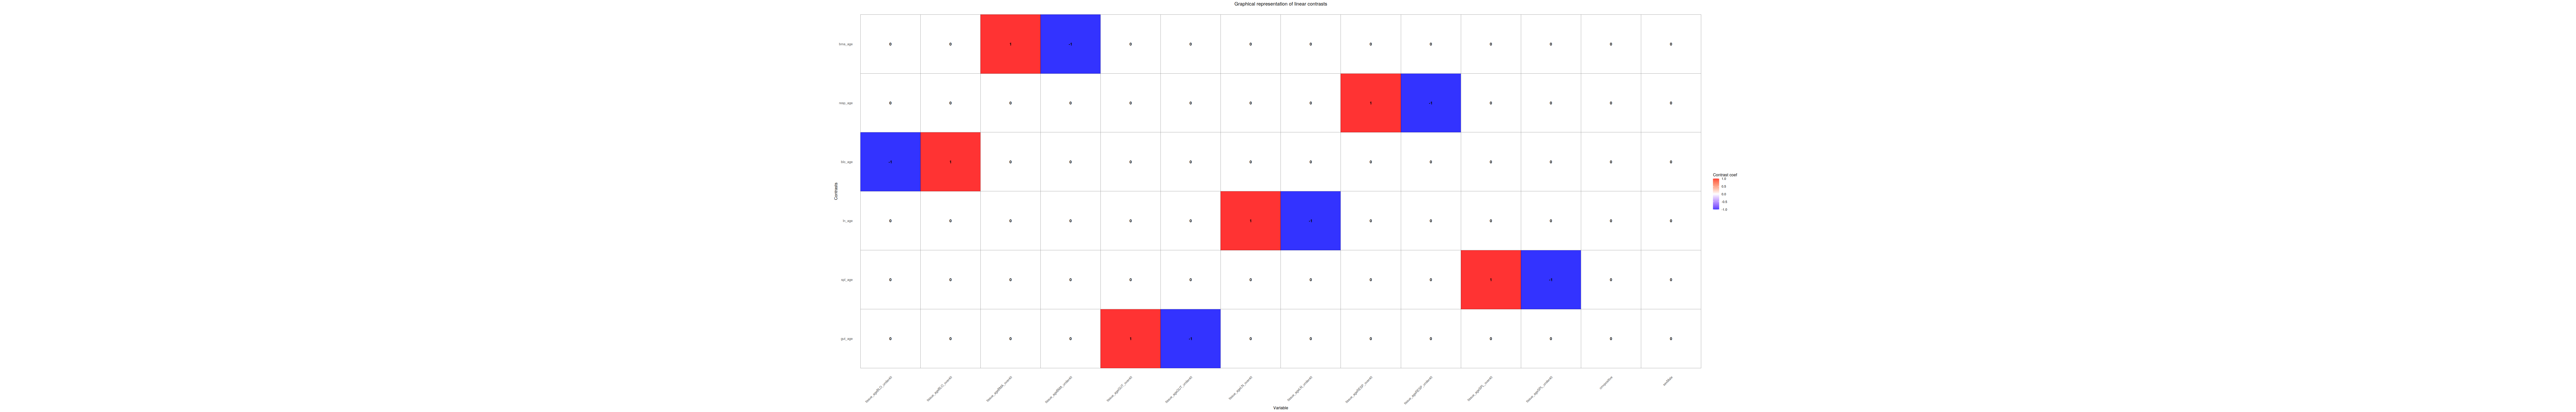

In [86]:
form <- ~ tissue_age + cmv + sex + (1|chemistry) + (1|site) + 0

# Define contrasts
# Note that for each contrass, the weights sum to 1
L <- makeContrastsDream(form, colData(res.proc), contrasts = c(
    gut_age = "tissue_ageGUT_over40 - tissue_ageGUT_under40",
    spl_age = "tissue_ageSPL_over40 - tissue_ageSPL_under40",
    ln_age = "tissue_ageLN_over40 - tissue_ageLN_under40",
    blo_age = "tissue_ageBLO_over40 - tissue_ageBLO_under40",
    resp_age = "tissue_ageRESP_over40 - tissue_ageRESP_under40",
    bma_age = "tissue_ageBMA_over40 - tissue_ageBMA_under40")
)

plotContrasts(L)

In [93]:
celltypes = c()
for (i in assayNames(res.proc)){
    count <- sum(grepl("_", rownames(assay(res.proc, i)$targets)))
    print(paste0(i, '   contains n samples  ', count))
    if(count > 30) {
        celltypes <- c(celltypes, i)
    }
}
celltypes

[1] "b_age   contains n samples  15"
[1] "b_gc   contains n samples  18"
[1] "b_memory   contains n samples  151"
[1] "b_naive   contains n samples  139"
[1] "cd3_gd   contains n samples  110"
[1] "cd4_cm   contains n samples  159"
[1] "cd4_naive   contains n samples  137"
[1] "cd4_tem   contains n samples  146"
[1] "cd4_temra   contains n samples  59"
[1] "cd4_treg   contains n samples  160"
[1] "cd4_trm   contains n samples  154"
[1] "cd8_cm   contains n samples  70"
[1] "cd8_mait   contains n samples  79"
[1] "cd8_naive   contains n samples  133"
[1] "cd8_tem   contains n samples  137"
[1] "cd8_temra   contains n samples  138"
[1] "cd8_trm   contains n samples  160"
[1] "dc1   contains n samples  11"
[1] "dc2   contains n samples  57"
[1] "dc_migratory   contains n samples  20"
[1] "ilc1   contains n samples  40"
[1] "ilc3   contains n samples  80"
[1] "macrophage   contains n samples  131"
[1] "mast_cell   contains n samples  67"
[1] "monocyte_classical   contains n samples  111"
[

[1] "b_memory"              "b_naive"               "cd3_gd"               
 [4] "cd4_cm"                "cd4_naive"             "cd4_tem"              
 [7] "cd4_temra"             "cd4_treg"              "cd4_trm"              
[10] "cd8_cm"                "cd8_mait"              "cd8_naive"            
[13] "cd8_tem"               "cd8_temra"             "cd8_trm"              
[16] "dc2"                   "ilc1"                  "ilc3"                 
[19] "macrophage"            "mast_cell"             "monocyte_classical"   
[22] "monocyte_nonclassical" "nk_cd56br"             "nk_cd56dim"           
[25] "nk_ilc_precursor"      "plasma_cell"           "plasmablast"

In [95]:
form <- ~ tissue_age + cmv + sex + (1|chemistry) + (1|site) + 0

# Differential expression analysis within each assay,
# evaluated on the voom normalized data
res.dl2 <- dreamlet(
    res.proc,
    form,
    assays=celltypes,
    colData(res.proc),
    contrasts = c(
        gut_age = "tissue_ageGUT_over40 - tissue_ageGUT_under40",
        spl_age = "tissue_ageSPL_over40 - tissue_ageSPL_under40",
        ln_age = "tissue_ageLN_over40 - tissue_ageLN_under40",
        blo_age = "tissue_ageBLO_over40 - tissue_ageBLO_under40",
        resp_age = "tissue_ageRESP_over40 - tissue_ageRESP_under40",
        bma_age = "tissue_ageBMA_over40 - tissue_ageBMA_under40"),
    computeResiduals=TRUE,
    BPPARAM=multicoreParam
)

# names of estimated coefficients
coefNames(res.dl2) 

  b_memory...
14 mins

  b_naive...
12 mins

  cd3_gd...
6.9 mins

  cd4_cm...
14 mins

  cd4_naive...
13 mins

  cd4_tem...
10 mins

  cd4_temra...
Warning message:
“makeContrastsDream: object 'tissue_ageGUT_under40' not found”
3.8 mins

  cd4_treg...
9.2 mins

  cd4_trm...
Warning message:
“makeContrastsDream: object 'tissue_ageBLO_under40' not found”
13 mins

  cd8_cm...
Warning message:
“makeContrastsDream: object 'tissue_ageGUT_over40' not found”
3.1 mins

  cd8_mait...
3.6 mins

  cd8_naive...
10 mins

  cd8_tem...
7.5 mins

  cd8_temra...
6.4 mins

  cd8_trm...
11 mins

  dc2...
6.9 mins

  ilc1...
Warning message:
“makeContrastsDream: object 'tissue_ageSPL_over40' not found”
Warning message:
“makeContrastsDream: object 'tissue_ageLN_under40' not found”
Warning message:
“makeContrastsDream: object 'tissue_ageBMA_over40' not found”
7.9 mins

  ilc3...
Warning message:
“makeContrastsDream: object 'tissue_ageBLO_under40' not found”
3.8 mins

  macrophage...
8.8 mins

  mast_cell...

[1] "gut_age"                "spl_age"                "ln_age"                
 [4] "blo_age"                "resp_age"               "bma_age"               
 [7] "tissue_ageBLO_under40"  "tissue_ageBLO_over40"   "tissue_ageBMA_over40"  
[10] "tissue_ageBMA_under40"  "tissue_ageGUT_over40"   "tissue_ageGUT_under40" 
[13] "tissue_ageLN_over40"    "tissue_ageLN_under40"   "tissue_ageRESP_over40" 
[16] "tissue_ageRESP_under40" "tissue_ageSPL_over40"   "tissue_ageSPL_under40" 
[19] "cmvpositive"            "sexMale"

Warning message:
“Removed 7 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 58 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


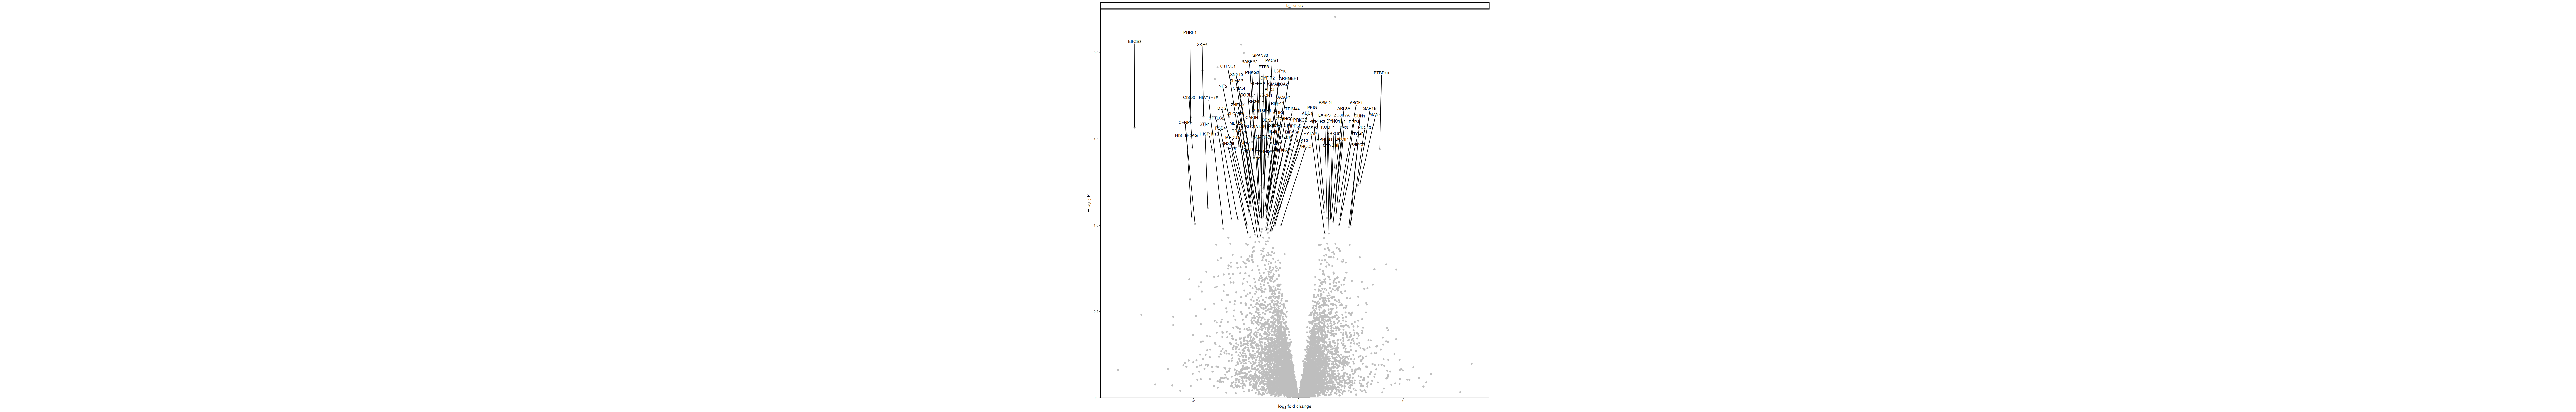

In [97]:
plotVolcano(res.dl2, coef='gut_age', nGenes=100, assay='b_memory')

In [102]:
for (i in c('gut_age', 'spl_age', 'ln_age', 'blo_age', 'resp_age', 'bma_age')){
    table <- topTable(res.dl2, coef=i, number=Inf)
    write.csv(table, paste0("results_dreamlet_fine/aging_", i, "_random.csv"))
}

In [104]:
form <- ~ tissue_age + cmv + sex + chemistry + site + 0

# Differential expression analysis within each assay,
# evaluated on the voom normalized data
res.dl <- dreamlet(
    res.proc,
    form,
    assays=celltypes,
    colData(res.proc),
    contrasts = c(
        gut_age = "tissue_ageGUT_over40 - tissue_ageGUT_under40",
        spl_age = "tissue_ageSPL_over40 - tissue_ageSPL_under40",
        ln_age = "tissue_ageLN_over40 - tissue_ageLN_under40",
        blo_age = "tissue_ageBLO_over40 - tissue_ageBLO_under40",
        resp_age = "tissue_ageRESP_over40 - tissue_ageRESP_under40",
        bma_age = "tissue_ageBMA_over40 - tissue_ageBMA_under40"),
    computeResiduals=TRUE,
    BPPARAM=multicoreParam
)

# names of estimated coefficients
coefNames(res.dl) 

  b_memory...
27 secs

  b_naive...
21 secs

  cd3_gd...
9.4 secs

  cd4_cm...
26 secs

  cd4_naive...
17 secs

  cd4_tem...
19 secs

  cd4_temra...
Warning message:
“makeContrastsDream: object 'tissue_ageGUT_under40' not found”
3.9 secs

  cd4_treg...
17 secs

  cd4_trm...
Warning message:
“makeContrastsDream: object 'tissue_ageBLO_under40' not found”
19 secs

  cd8_cm...
Warning message:
“makeContrastsDream: object 'tissue_ageGUT_over40' not found”
2.8 secs

  cd8_mait...
3.3 secs

  cd8_naive...
15 secs

  cd8_tem...
10 secs

  cd8_temra...
7.2 secs

  cd8_trm...
15 secs

  dc2...
5.9 secs

  ilc1...
Warning message:
“makeContrastsDream: object 'tissue_ageSPL_over40' not found”
Warning message:
“makeContrastsDream: object 'tissue_ageLN_under40' not found”
Warning message:
“makeContrastsDream: object 'tissue_ageBMA_over40' not found”
6.7 secs

  ilc3...
Warning message:
“makeContrastsDream: object 'tissue_ageBLO_under40' not found”
5.1 secs

  macrophage...
9.7 secs

  mast_cell...
W

[1] "gut_age"                "spl_age"                "ln_age"                
 [4] "blo_age"                "resp_age"               "bma_age"               
 [7] "tissue_ageBLO_under40"  "tissue_ageBLO_over40"   "tissue_ageBMA_over40"  
[10] "tissue_ageBMA_under40"  "tissue_ageGUT_over40"   "tissue_ageGUT_under40" 
[13] "tissue_ageLN_over40"    "tissue_ageLN_under40"   "tissue_ageRESP_over40" 
[16] "tissue_ageRESP_under40" "tissue_ageSPL_over40"   "tissue_ageSPL_under40" 
[19] "cmvpositive"            "sexMale"                "chemistry5'v2"         
[22] "siteUK"

Warning message:
“Removed 7 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 58 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


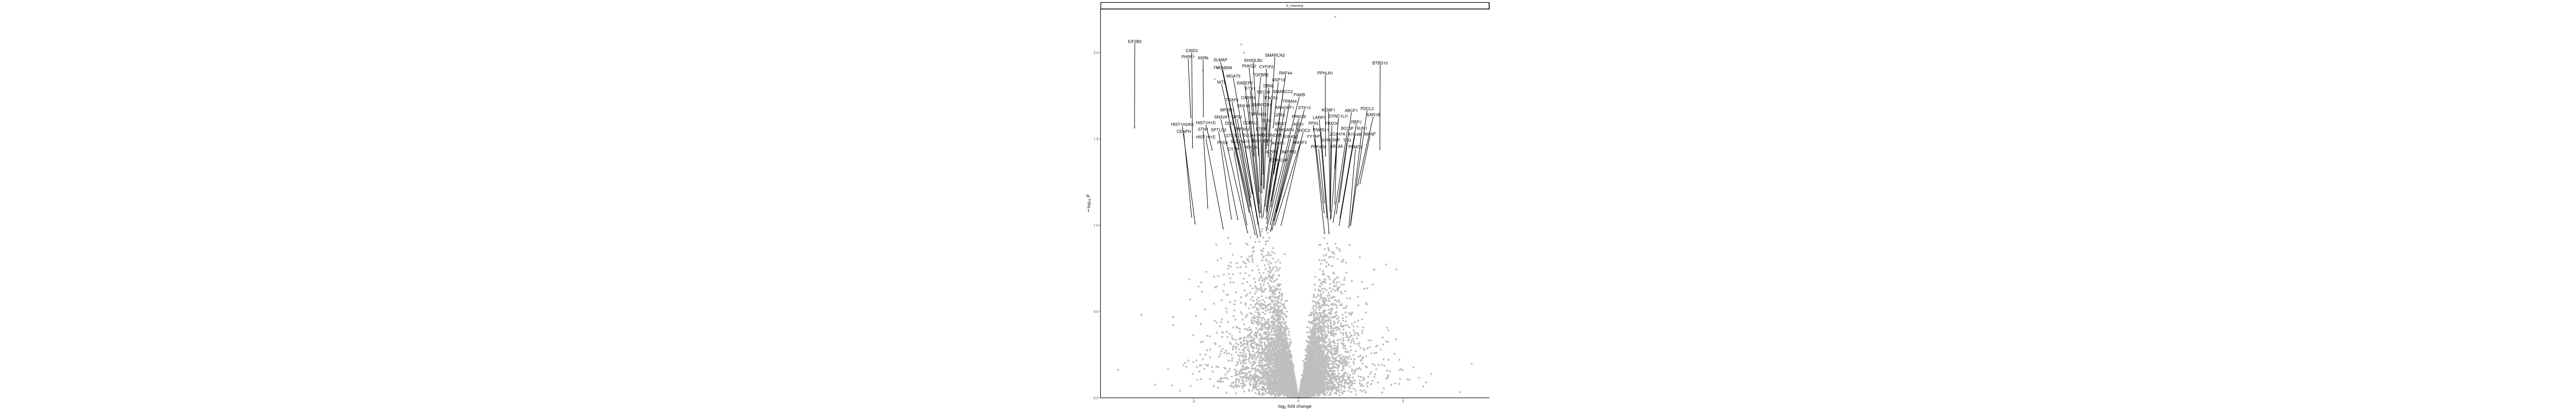

In [105]:
plotVolcano(res.dl2, coef='gut_age', nGenes=100, assay='b_memory')

In [ ]:
for (i in c('gut_age', 'spl_age', 'ln_age', 'blo_age', 'resp_age', 'bma_age')){
    table <- topTable(res.dl, coef=i, number=Inf)
    write.csv(table, paste0("results_dreamlet_fine/aging_", i, ".csv"))
}